# Import library

In [2]:
import cv2
import os
from cv2 import imread
from cv2 import fillPoly
from shapely import wkt
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as kutils
import sklearn.ensemble
import sklearn.metrics
import rasterio
import os
import json
import pandas as pd
import dlmodels

c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Data pre-processing

We select **Hurricane Mathew** event

## Read image

In [4]:
# define constants
image_folder = 'train/images'
bulding_folder = 'train/buildings'
labels_folder = 'train/labels'

In [5]:
pre_image_files = []
post_image_files = []
pre_building_files = []
post_building_files = []

for root, dirs, files in os.walk(image_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("pre" in file):
            pre_image_files.append(imread(os.path.join(root, file)))
        elif ("hurricane-matthew" in file) and ("post" in file):
            post_image_files.append(imread(os.path.join(root, file)))

for root, dirs, files in os.walk(image_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("pre" in file):
            pre_building_files.append(imread(os.path.join(root, file)))
        elif ("hurricane-matthew" in file) and ("post" in file):
            post_building_files.append(imread(os.path.join(root, file)))

In [6]:
print(len(pre_image_files))
print(len(post_image_files))

238
238


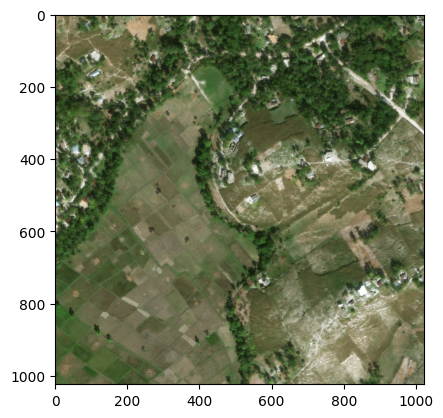

In [7]:
img = mpimg.imread('train/images/hurricane-matthew_00000005_pre_disaster.png')
imgplot = plt.imshow(img)
plt.show()

## Read polygon and explore data

In [8]:
count = 0
for root, dirs, files in os.walk(labels_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("post" in file) and (count==0):
            test = json.load(open(os.path.join(root, file)))
            main_df = pd.json_normalize(test, record_path=['features', 'lng_lat'])
            main_df['image'] = file.split('.')[0]
            count += 1
        elif ("hurricane-matthew" in file) and ("post" in file):
            test = json.load(open(os.path.join(root, file)))
            df = pd.json_normalize(test, record_path=['features', 'lng_lat'])
            df['image'] = file.split('.')[0]
            main_df = pd.concat([main_df, df], ignore_index=True)

In [9]:
main_df

,wkt,properties.feature_type,properties.subtype,properties.uid,image
0,POLYGON ((-73.73999821958201 18.19645168390706...,building,minor-damage,6dd06e25-353d-4ca2-8a93-bbdd44b10435,hurricane-matthew_00000000_post_disaster
1,POLYGON ((-73.74012695415038 18.19649906723468...,building,minor-damage,29ea07d6-33b5-4c85-9a80-20eea786ab2f,hurricane-matthew_00000000_post_disaster
2,"POLYGON ((-73.74014403688365 18.1965502302046,...",building,minor-damage,25e32d78-3761-443d-8afb-e4b1d575ad30,hurricane-matthew_00000000_post_disaster
3,POLYGON ((-73.74006042030388 18.19652266297088...,building,minor-damage,63591a27-a002-4c86-a02c-e5c4282339cc,hurricane-matthew_00000000_post_disaster
4,POLYGON ((-73.74005471031927 18.19658868660606...,building,minor-damage,5416393e-158e-4bee-9f93-b70df29eab02,hurricane-matthew_00000000_post_disaster
...,...,...,...,...,...
13934,POLYGON ((-74.09714968659425 18.27231201919512...,building,destroyed,ceb3124e-0183-42e8-a26b-38c7844184cf,hurricane-matthew_00000401_post_disaster
13935,POLYGON ((-74.09774801834411 18.27229347634119...,building,destroyed,e748416c-b2f2-4aaf-aefa-89c5ff6468bd,hurricane-matthew_00000401_post_disaster
13936,POLYGON ((-74.09658657078509 18.27343661200825...,building,destroyed,060bbf4b-6dc6-42e1-b325-e75f819ab1f0,hurricane-matthew_00000401_post_disaster
13937,"POLYGON ((-74.09638183743883 18.273897772937, ...",building,destroyed,3627d4d1-2bb5-4406-aec0-00f8a88c87c7,hurricane-matthew_00000401_post_disaster


In [10]:
main_df.groupby(['image', 'properties.subtype']).count()

wkt  \
image                                    properties.subtype        
hurricane-matthew_00000000_post_disaster destroyed             3   
                                         major-damage          2   
                                         minor-damage         97   
                                         no-damage             3   
hurricane-matthew_00000001_post_disaster destroyed             1   
...                                                          ...   
hurricane-matthew_00000400_post_disaster destroyed            53   
                                         major-damage         16   
                                         un-classified         1   
hurricane-matthew_00000401_post_disaster destroyed            77   
                                         major-damage          7   

                                                             properties.feature_type  \
image                                    properties.subtype                            
hurricane-matthew_00000000_post_disaster destroyed                                 3   
                                         major-damage                              2   
                                         minor-damage                             97   
                                         no-damage                                 3   
hurricane-matthew_00000001_post_disaster destroyed                                 1   
...                                                                              ...   
hurricane-matthew_00000400_post_disaster destroyed                                53   
                                         major-damage                             16   
                                         un-classified                             1   
hurricane-matthew_00000401_post_disaster destroyed                                77   
                                         major-damage                              7   

                                                             properties.uid  
image                                    properties.subtype                  
hurricane-matthew_00000000_post_disaster destroyed                        3  
                                         major-damage                     2  
                                         minor-damage                    97  
                                         no-damage                        3  
hurricane-matthew_00000001_post_disaster destroyed                        1  
...                                                                     ...  
hurricane-matthew_00000400_post_disaster destroyed                       53  
                                         major-damage                    16  
                                         un-classified                    1  
hurricane-matthew_00000401_post_disaster destroyed                       77  
                                         major-damage                     7  

[751 rows x 3 columns]

## Mask Polygon (create ground truth in raster format)

In [11]:
output_path = 'train/mask_polygon'

damage_dict = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 5
}

for root, dirs, files in os.walk(labels_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("post" in file):
            polygons = json.load(open(os.path.join(root, file)))
            h = polygons["metadata"]["height"]
            w = polygons["metadata"]["width"]
            mask_img = np.zeros((h, w), np.uint8)
            for feature in polygons['features']['xy']:
                feature_poly = wkt.loads(feature['wkt'])
                coords = list(mapping(feature_poly)['coordinates'][0])
                fillPoly(mask_img, [np.array(coords, np.int32)], damage_dict[feature['properties']['subtype']])
            output_name = file.split('.')[0] + ".png"
            isExist = os.path.exists(output_path)
            if not isExist:
                os.makedirs(output_path)
            cv2.imwrite(os.path.join('train/mask_polygon', output_name), mask_img)

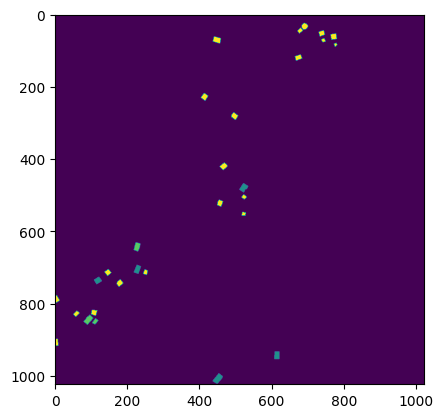

In [12]:
img = mpimg.imread('train/mask_polygon/hurricane-matthew_00000211_post_disaster.png')
imgplot = plt.imshow(img)
plt.show()

In [13]:
test = imread('train/mask_polygon/hurricane-matthew_00000211_post_disaster.png')

In [14]:
np.unique(test)

array([0, 2, 3, 4], dtype=uint8)

## Prepare image patches

This part of code is modified from Classification of very high resolution satellite images using fully convolutional networks (Slum Segmentation Exercise) developed by Konstantin Maslov.

In [15]:
# define constants
BANDS_COUNT = 3

PATCH_SIZE = 128
BATCH_SIZE = 4

EPOCHS = 10
STEPS = 200

def read_image(image_path):
    with rasterio.open(image_path) as image_file:
        height, width, depth = image_file.height, image_file.width, image_file.count
        image_arr = np.empty((height, width, depth))
        for band_idx in range(depth):
            band_arr = image_file.read(band_idx + 1)
            image_arr[:, :, band_idx] = band_arr
    return image_arr

def labels_to_onehot(labels_arr, classes_count):
    height, width, _ = labels_arr.shape
    labels_arr = labels_arr[:, :, 0] 
    labels_onehot = np.zeros((height, width, classes_count))
    for class_idx in range(classes_count):
        labels_onehot[:, :, class_idx][labels_arr == class_idx] = 1
    return labels_onehot

def pad_image_to_patch_size(image, patch_size=PATCH_SIZE):
    height, width, depth = image.shape
    target_height = patch_size * int(height // patch_size + 1)
    target_width = patch_size * int(width // patch_size + 1)
    pad_height = (target_height - height) // 2
    pad_width = (target_width - width) // 2
    padded = np.zeros((target_height, target_width, depth))
    padded[pad_height:pad_height + height, pad_width:pad_width + width, :] = image
    return padded, (pad_height, pad_width)

I modified TrainSequence function to make it be more dynamic.
Extra arguments
- process: localization (for building localization), classification (for damage classsification)
- classes_count: 2 (for localization task), 6 (for classification task)
- image_set: default is 'None' (for damage classification task), pre (for pre-disaster image), post (for post-disaster image)

In [16]:
import random

class TrainSequence(kutils.Sequence):
    def __init__(self, folder_path, batch_size, patch_size, len, process, classes_count, threshold, image_set='None'):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.len = len
        self.process = process
        self.image_set = image_set
        self.classes_count = classes_count
        self.threshold = threshold
        self.read_dataset()
        self.reset()

    def read_dataset(self):
        # print('read dataset')
        self.data = []
        # self.len = 0
        pre_image_files = []
        post_image_files = []
        label_files = []
        count = 0
        for root, dirs, files in os.walk(self.folder_path+'/images'):
            for file in files:
                if self.process == 'localization':
                    if self.image_set == 'pre':
                         if ("hurricane-matthew" in file) and ("pre" in file):
                            image = imread(os.path.join(root, file))
                            # image, _ = pad_image_to_patch_size(pre_img)
                            pre_image_files.append(image)
                            count += 1
                    else:
                        if ("hurricane-matthew" in file) and ("post" in file):
                            post_img = imread(os.path.join(root, file))
                            # image, _ = pad_image_to_patch_size(post_img)
                            post_image_files.append(post_img)
                            count += 1
                else:
                    if ("hurricane-matthew" in file) and ("pre" in file):
                        image = imread(os.path.join(root, file))
                        # image, _ = pad_image_to_patch_size(pre_img)
                        pre_image_files.append(image)
                        count += 1
                    elif ("hurricane-matthew" in file) and ("post" in file):
                        image = imread(os.path.join(root, file))
                        # image, _ = pad_image_to_patch_size(post_img)
                        post_image_files.append(image)
                        count += 1
                    # if count == 100:
                    #     break
                if count == self.threshold:
                    # print('break')
                    break
        count = 0
        if self.process == 'localization':
            for root, dirs, files in os.walk(self.folder_path+'/targets'):
                for file in files:
                    if self.image_set == 'pre':
                         if ("hurricane-matthew" in file) and ("pre" in file):
                            label = imread(os.path.join(root, file))
                            # label, _ = pad_image_to_patch_size(label)
                            label = labels_to_onehot(label, self.classes_count)
                            label_files.append(label)
                            count += 1
                    else:
                        if ("hurricane-matthew" in file) and ("post" in file):
                            label = imread(os.path.join(root, file))
                            # label, _ = pad_image_to_patch_size(label)
                            label = labels_to_onehot(label)
                            label_files.append(label)
                            count += 1
                    if count == len(pre_image_files):
                        break
        else:
            for root, dirs, files in os.walk(self.folder_path+'/mask_polygon'):
                for file in files:
                    label = imread(os.path.join(root, file))
                    # label, _ = pad_image_to_patch_size(label)
                    label = labels_to_onehot(label, self.classes_count)
                    label_files.append(label)
                    count += 1
                    if count == len(pre_image_files):
                        # print('break')
                        break
        
        for i in range(len(label_files)):
            if self.process == 'localization':
                if self.image_set == 'pre':
                    self.data.append((pre_image_files[i], label_files[i]))
                else:
                    self.data.append((post_image_files[i], label_files[i]))
                # height, width, _ = image.shape
                # patches_count = (height // self.patch_size) * (width // self.patch_size)
                # self.len += patches_count
            else:
                self.data.append((pre_image_files[i], post_image_files[i], label_files[i]))
                # height, width, _ = image.shape
                # patches_count = (height // self.patch_size) * (width // self.patch_size)
                # self.len += patches_count
        # print(len(self.data))

    def __len__(self):
        # print(f"Sequence length: {self.len}")
        return self.len

    def __getitem__(self, idx):
        # print('Get item')
        success = False
        if self.process == 'localization':
            batch_x = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
            batch_y = np.empty((self.batch_size, self.patch_size, self.patch_size, self.classes_count))
            for patch_index in range(self.batch_size):
                while not success:
                    image = self.sample_image()
                    patch_image, patch_label = self.sample_patch(image)
                    # print(np.sum(patch_label, axis=0)[:, 0].shape)
                    if np.sum(np.sum(patch_label, axis=0)[:, 0]) != 16384:
                        success = True
                    # else:
                    #     self.len -= 1
                # image = self.sample_image()
                # patch_image, patch_label = self.sample_patch(image)
                batch_x[patch_index] = patch_image
                batch_y[patch_index] = patch_label
                success = False
            return batch_x, batch_y
        else:
            batch_pre_img = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
            batch_post_img = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
            batch_y = np.empty((self.batch_size, self.patch_size, self.patch_size, self.classes_count))
            for patch_index in range(self.batch_size):
                image = self.sample_image()
                patch_pre_image, patch_post_image, patch_label = self.sample_patch(image)
                batch_pre_img[patch_index] = patch_pre_image
                batch_post_img[patch_index] = patch_post_image
                batch_y[patch_index] = patch_label
            return batch_pre_img, batch_post_img, batch_y

    def sample_image(self):
        if self.image_index >= len(self.data):
            # print('reset')
            self.reset()
        # image_index = np.random.choice(len(self.data))
        if self.process == 'localization':
            image, label = self.data[self.image_index]
            return image, label
        else:
            pre_image, post_image, label = self.data[self.image_index]
            return pre_image, post_image, label

    def sample_patch(self, image_label_pair):
        if self.process == 'localization':
            image, label = image_label_pair
            height, width, _ = image.shape
            # print(height, width)
            if self.x + self.patch_size > width:
                self.x = 0
                self.y += self.patch_size
                # print(self.y)
            if self.y + self.patch_size > height:
                # print('in')
                self.y = 0
                self.x = 0
                self.image_index += 1
                image, label = self.sample_image()
            
            patch_image = image[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            patch_label = label[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            self.x += self.patch_size
            return patch_image, patch_label
            # y = np.random.choice(height - self.patch_size)
            # x = np.random.choice(width - self.patch_size)
            # patch_image = image[y:y + self.patch_size, x:x + self.patch_size, :]
            # patch_label = label[y:y + self.patch_size, x:x + self.patch_size, :]
            # return patch_image, patch_label
        else:
            pre_image, post_image, label = image_label_pair
            height, width, _ = pre_image.shape
            # print(height, width)
            if self.x + self.patch_size > width:
                self.x = 0
                self.y += self.patch_size
                # print(self.y)
            if self.y + self.patch_size > height:
                # print('in')
                self.y = 0
                self.x = 0
                self.image_index += 1
                image, label = self.sample_image()
            
            patch_pre_image = pre_image[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            patch_post_image = post_image[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            patch_label = label[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            self.x += self.patch_size
            return patch_pre_image, patch_post_image, patch_label
            # y = np.random.choice(height - self.patch_size)
            # x = np.random.choice(width - self.patch_size)
            # patch_pre_image = pre_image[y:y + self.patch_size, x:x + self.patch_size, :]
            # patch_post_image = post_image[y:y + self.patch_size, x:x + self.patch_size, :]
            # patch_label = label[y:y + self.patch_size, x:x + self.patch_size, :]
            # return patch_pre_image, patch_post_image, patch_label
        
    def reset(self):
        self.image_index = 0
        self.x = 0
        self.y = 0

In [17]:
class ValSequence(kutils.Sequence):
    def __init__(self, folder_path, batch_size, patch_size, process, classes_count, threshold, image_set='None'):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.patch_size = patch_size
        # self.len = len
        self.process = process
        self.image_set = image_set
        self.classes_count = classes_count
        self.threshold = threshold
        self.read_dataset()
        self.reset()

    def read_dataset(self):
        # print('read dataset')
        self.data = []
        self.len = 0
        pre_image_files = []
        post_image_files = []
        label_files = []
        count = 0
        for root, dirs, files in os.walk(self.folder_path+'/images'):
            for file in files:
                if self.process == 'localization':
                    if self.image_set == 'pre':
                         if ("hurricane-matthew" in file) and ("pre" in file):
                            image = imread(os.path.join(root, file))
                            # image, _ = pad_image_to_patch_size(pre_img)
                            pre_image_files.append(image)
                            count += 1
                    else:
                        if ("hurricane-matthew" in file) and ("post" in file):
                            post_img = imread(os.path.join(root, file))
                            # image, _ = pad_image_to_patch_size(post_img)
                            post_image_files.append(post_img)
                            count += 1
                else:
                    if ("hurricane-matthew" in file) and ("pre" in file):
                        image = imread(os.path.join(root, file))
                        # image, _ = pad_image_to_patch_size(pre_img)
                        pre_image_files.append(image)
                        count += 1
                    elif ("hurricane-matthew" in file) and ("post" in file):
                        image = imread(os.path.join(root, file))
                        # image, _ = pad_image_to_patch_size(post_img)
                        post_image_files.append(image)
                        count += 1
                    # if count == 100:
                    #     break
                if count == self.threshold:
                    # print('break')
                    break
        count = 0
        if self.process == 'localization':
            for root, dirs, files in os.walk(self.folder_path+'/targets'):
                for file in files:
                    if self.image_set == 'pre':
                         if ("hurricane-matthew" in file) and ("pre" in file):
                            label = imread(os.path.join(root, file))
                            # label, _ = pad_image_to_patch_size(label)
                            label = labels_to_onehot(label, self.classes_count)
                            label_files.append(label)
                            count += 1
                    else:
                        if ("hurricane-matthew" in file) and ("post" in file):
                            label = imread(os.path.join(root, file))
                            # label, _ = pad_image_to_patch_size(label)
                            label = labels_to_onehot(label)
                            label_files.append(label)
                            count += 1
                    if count == len(pre_image_files):
                        break
        else:
            for root, dirs, files in os.walk(self.folder_path+'/mask_polygon'):
                for file in files:
                    label = imread(os.path.join(root, file))
                    # label, _ = pad_image_to_patch_size(label)
                    label = labels_to_onehot(label, self.classes_count)
                    label_files.append(label)
                    count += 1
                    if count == len(pre_image_files):
                        # print('break')
                        break
        
        for i in range(len(label_files)):
            if self.process == 'localization':
                if self.image_set == 'pre':
                    self.data.append((pre_image_files[i], label_files[i]))
                else:
                    self.data.append((post_image_files[i], label_files[i]))
                height, width, _ = image.shape
                patches_count = (height // self.patch_size) * (width // self.patch_size)
                self.len += patches_count
            else:
                self.data.append((pre_image_files[i], post_image_files[i], label_files[i]))
                height, width, _ = image.shape
                patches_count = (height // self.patch_size) * (width // self.patch_size)
                self.len += patches_count
        # print(len(self.data))

    def __len__(self):
        # print(f"Sequence length: {self.len}")
        return self.len

    def __getitem__(self, idx):
        # print('Get item')
        # success = False
        if self.process == 'localization':
            batch_x = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
            batch_y = np.empty((self.batch_size, self.patch_size, self.patch_size, self.classes_count))
            for patch_index in range(self.batch_size):
                # while not success:
                #     image = self.sample_image()
                #     patch_image, patch_label = self.sample_patch(image)
                #     # print(np.sum(patch_label, axis=0)[:, 0].shape)
                #     if np.sum(np.sum(patch_label, axis=0)[:, 0]) != 16384:
                #         success = True
                #     # else:
                #     #     self.len -= 1
                image = self.sample_image()
                patch_image, patch_label = self.sample_patch(image)
                batch_x[patch_index] = patch_image
                batch_y[patch_index] = patch_label
                # success = False
            return batch_x, batch_y
        else:
            batch_pre_img = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
            batch_post_img = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
            batch_y = np.empty((self.batch_size, self.patch_size, self.patch_size, self.classes_count))
            for patch_index in range(self.batch_size):
                image = self.sample_image()
                patch_pre_image, patch_post_image, patch_label = self.sample_patch(image)
                batch_pre_img[patch_index] = patch_pre_image
                batch_post_img[patch_index] = patch_post_image
                batch_y[patch_index] = patch_label
            return batch_pre_img, batch_post_img, batch_y

    def sample_image(self):
        if self.image_index >= len(self.data):
            # print('reset')
            self.reset()
        # image_index = np.random.choice(len(self.data))
        if self.process == 'localization':
            image, label = self.data[self.image_index]
            return image, label
        else:
            pre_image, post_image, label = self.data[self.image_index]
            return pre_image, post_image, label

    def sample_patch(self, image_label_pair):
        if self.process == 'localization':
            image, label = image_label_pair
            height, width, _ = image.shape
            # print(height, width)
            if self.x + self.patch_size > width:
                self.x = 0
                self.y += self.patch_size
                # print(self.y)
            if self.y + self.patch_size > height:
                # print('in')
                self.y = 0
                self.x = 0
                self.image_index += 1
                image, label = self.sample_image()
            
            patch_image = image[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            patch_label = label[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            self.x += self.patch_size
            return patch_image, patch_label
            # y = np.random.choice(height - self.patch_size)
            # x = np.random.choice(width - self.patch_size)
            # patch_image = image[y:y + self.patch_size, x:x + self.patch_size, :]
            # patch_label = label[y:y + self.patch_size, x:x + self.patch_size, :]
            # return patch_image, patch_label
        else:
            pre_image, post_image, label = image_label_pair
            height, width, _ = pre_image.shape
            # print(height, width)
            if self.x + self.patch_size > width:
                self.x = 0
                self.y += self.patch_size
                # print(self.y)
            if self.y + self.patch_size > height:
                # print('in')
                self.y = 0
                self.x = 0
                self.image_index += 1
                image, label = self.sample_image()
            
            patch_pre_image = pre_image[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            patch_post_image = post_image[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            patch_label = label[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
            self.x += self.patch_size
            return patch_pre_image, patch_post_image, patch_label
            # y = np.random.choice(height - self.patch_size)
            # x = np.random.choice(width - self.patch_size)
            # patch_pre_image = pre_image[y:y + self.patch_size, x:x + self.patch_size, :]
            # patch_post_image = post_image[y:y + self.patch_size, x:x + self.patch_size, :]
            # patch_label = label[y:y + self.patch_size, x:x + self.patch_size, :]
            # return patch_pre_image, patch_post_image, patch_label
        
    def reset(self):
        self.image_index = 0
        self.x = 0
        self.y = 0

[]

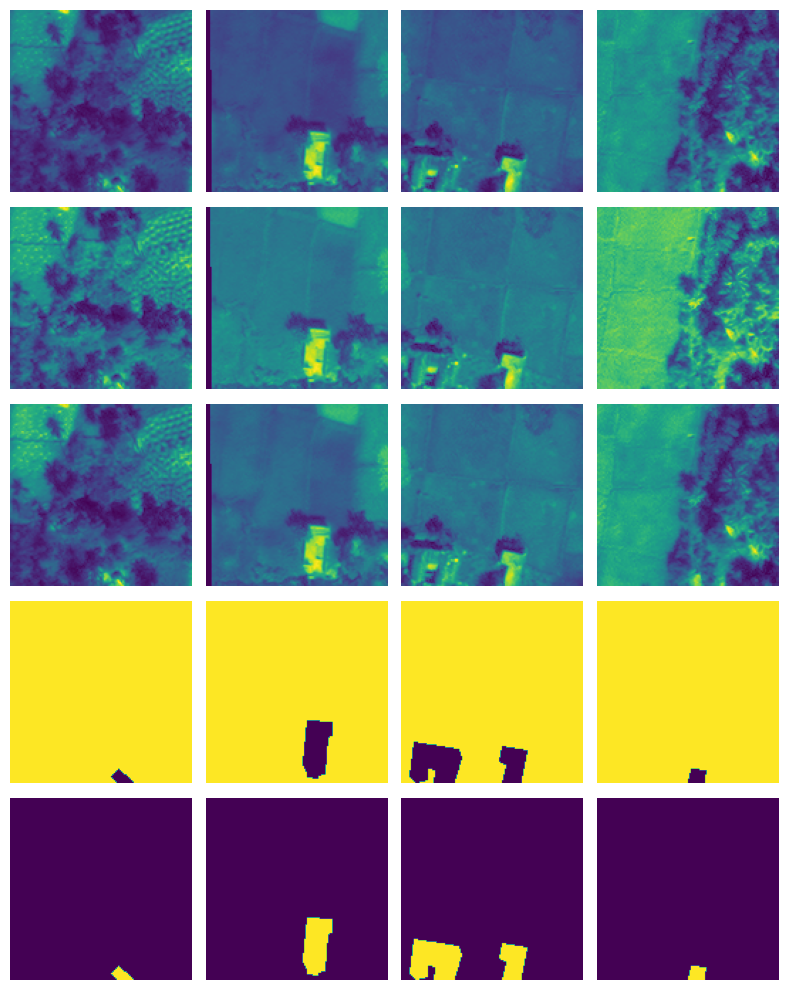

In [18]:
CLASSES_COUNT = 2
train_sequence = TrainSequence('train', BATCH_SIZE, PATCH_SIZE, 700, 'localization', CLASSES_COUNT, 30, 'pre')
val_sequence = ValSequence('test', BATCH_SIZE, PATCH_SIZE, 'localization', CLASSES_COUNT, 2, 'pre')
# pre_img, post_img, y = train_sequence[0]
img, y = train_sequence[0]
nrows, ncols = BANDS_COUNT + CLASSES_COUNT, BATCH_SIZE
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))

# for index, (x_item, y_item) in enumerate(zip(pre_img, y)):
for index, (x_item, y_item) in enumerate(zip(img, y)):
    for row in range(BANDS_COUNT):
        axes[row][index].imshow(x_item[:, :, row])
        axes[row][index].axis("off")
    for class_index in range(CLASSES_COUNT):
        row = BANDS_COUNT + class_index
        axes[row][index].imshow(y_item[:, :, class_index], vmin=0, vmax=1)
        axes[row][index].axis("off")

plt.tight_layout()
plt.plot()

[]

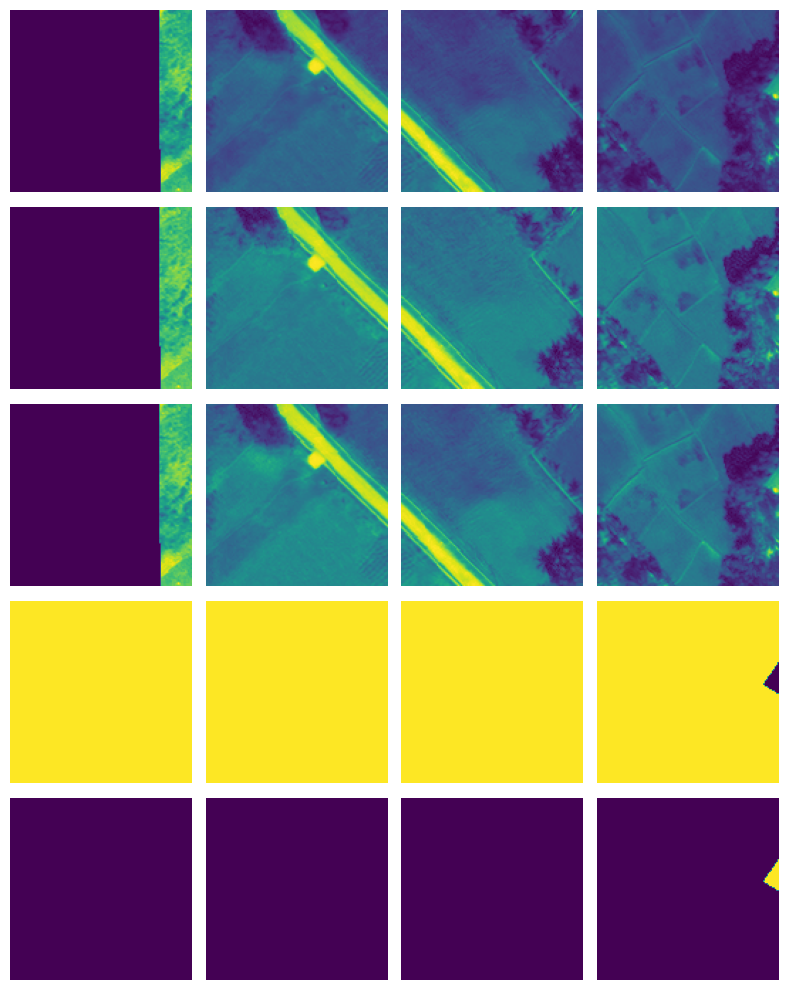

In [19]:
img, y = val_sequence[0]
nrows, ncols = BANDS_COUNT + CLASSES_COUNT, BATCH_SIZE
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))

# for index, (x_item, y_item) in enumerate(zip(pre_img, y)):
for index, (x_item, y_item) in enumerate(zip(img, y)):
    for row in range(BANDS_COUNT):
        axes[row][index].imshow(x_item[:, :, row])
        axes[row][index].axis("off")
    for class_index in range(CLASSES_COUNT):
        row = BANDS_COUNT + class_index
        axes[row][index].imshow(y_item[:, :, class_index], vmin=0, vmax=1)
        axes[row][index].axis("off")

plt.tight_layout()
plt.plot()

In [20]:
len(train_sequence)

700

In [21]:
len(val_sequence)

128

In [22]:
print(img.shape)
print(y.shape)

(4, 128, 128, 3)
(4, 128, 128, 2)


In [23]:
# print(pre_img.shape)
# print(post_img.shape)
# print(y.shape)

# Building localization

In [24]:
import dlmodels

model = dlmodels.unet((PATCH_SIZE, PATCH_SIZE, BANDS_COUNT), CLASSES_COUNT)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [25]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

history = model.fit(
    train_sequence, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_sequence
)

Epoch 1/10
700/700 [==============================] - 194s 258ms/step - loss: 0.2012 - accuracy: 0.9283 - val_loss: 0.1088 - val_accuracy: 0.9586
Epoch 2/10
700/700 [==============================] - 180s 257ms/step - loss: 0.1778 - accuracy: 0.9338 - val_loss: 0.0653 - val_accuracy: 0.9807
Epoch 3/10
700/700 [==============================] - 193s 276ms/step - loss: 0.1681 - accuracy: 0.9374 - val_loss: 0.1037 - val_accuracy: 0.9608
Epoch 4/10
700/700 [==============================] - 176s 251ms/step - loss: 0.1519 - accuracy: 0.9434 - val_loss: 0.1581 - val_accuracy: 0.9490
Epoch 5/10
700/700 [==============================] - 176s 251ms/step - loss: 0.1515 - accuracy: 0.9434 - val_loss: 0.0827 - val_accuracy: 0.9729
Epoch 6/10
700/700 [==============================] - 176s 251ms/step - loss: 0.1448 - accuracy: 0.9454 - val_loss: 0.0816 - val_accuracy: 0.9768
Epoch 7/10
700/700 [==============================] - 177s 252ms/step - loss: 0.1231 - accuracy: 0.9537 - val_loss: 0.0917 -

In [26]:
# save the weight of the trained network
model.save_weights("unet_weights_2.h5")

In [27]:
len(val_sequence)

128

In [28]:
len(train_sequence)

700

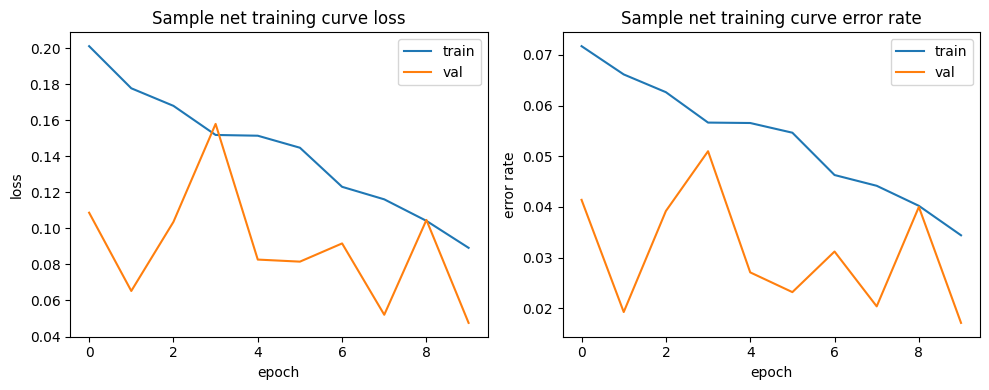

In [29]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history.history["accuracy"]], label="train")
axs[1].plot([1 - _ for _ in history.history["val_accuracy"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [30]:
loss, accuracy = model.evaluate(val_sequence)
print(f"\nValidation accuracy of U-Net: {100 * accuracy:.2f}%")

128/128 [==============================] - 10s 81ms/step - loss: 0.0476 - accuracy: 0.9829

Validation accuracy of U-Net: 98.29%


In [31]:
def apply_segmentation_with_fcn(image, fcn, patch_size=PATCH_SIZE, step=PATCH_SIZE//2):
    height, width, _ = image.shape
    # padded, (pad_height, pad_width) = pad_image_to_patch_size(image, patch_size)
    # height, width, _ = padded.shape
    
    predictions = np.zeros((height, width, CLASSES_COUNT))
    
    row = 0
    while row + patch_size <= height:
        row_patches = []

        col = 0 
        while col + patch_size <= width:
            patch = image[row:row + patch_size, col:col + patch_size, :]
            row_patches.append(patch)
            col += step

        batch = np.array(row_patches)
        row_predictions = fcn.predict(batch, verbose=0)

        col, patch_idx = 0, 0
        while col + patch_size <= width:
            predictions[row:row + patch_size, col:col + patch_size, :] += \
                row_predictions[patch_idx]
            col += step
            patch_idx += 1

        row += step

    # predictions = predictions[
    #     height,
    #     width, :
    # ]
    predictions = np.argmax(predictions, axis=-1)
    
    return predictions

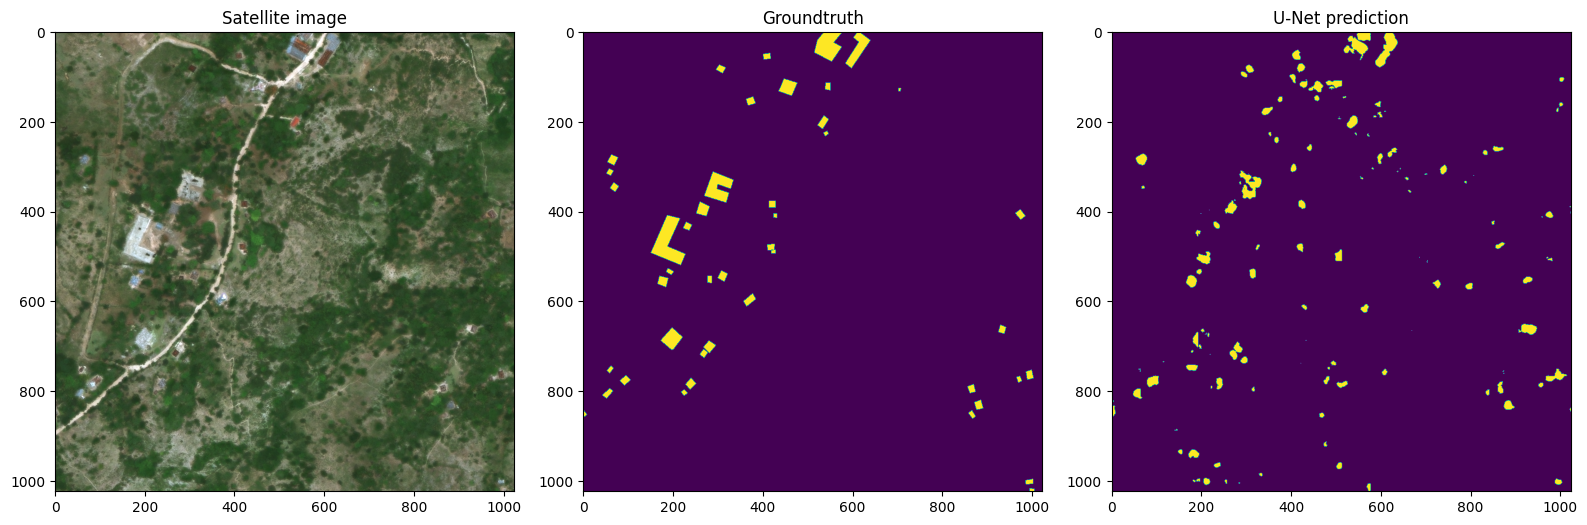

In [32]:
# let's classify one scene completely and see the results
SCENE_IDX = 0
image_path = 'test/images/hurricane-matthew_00000236_pre_disaster.png'
label_path = 'test/targets/hurricane-matthew_00000236_pre_disaster_target.png'

# image = read_image(image_path)
# label = read_image(label_path)
image = imread(image_path)
label = imread(label_path)

prediction = apply_segmentation_with_fcn(image, model)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

axs[0].imshow(image[:, :, [2, 1, 0]])
axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction")

plt.tight_layout()
plt.show()

# Load pre-trained model

In [1]:
model.load_weights("unet_weights_2.h5")

NameError: name 'model' is not defined

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

loss, accuracy = model.evaluate(val_sequence)
print(f"\nValidation accuracy of U-Net: {100 * accuracy:.2f}%")